In [85]:
# !pip install matplotlib

In [86]:
import numpy as np
from scipy.spatial.distance import cdist
import math
import pandas as pd
from matplotlib import pyplot as plt
DISTANCE_TYPE = 'euclidean'
DISTANCE_TYPE2 = 'cityblock'

In [87]:
def kmeans(dataset, k, no_of_iterations):
    indices = np.random.choice(len(dataset), k, replace = False)
    # print(indices)
    # choose the rows corresponding to indices which is randomly selected
    centroids = dataset.iloc[indices, :]
    # the below line finds the distance between centroids and all the datapoints
    distances = cdist(dataset, centroids, DISTANCE_TYPE)
    # print(centroids)
    # print(distances)
    # structure of distance => [[for one point mindistance from each centroid], ...]
    # the below line assigns each point with the nearest centroid
    points = np.array([np.argmin(dist_from_each_centroid) for dist_from_each_centroid in distances])
    
    # the main algo 
    for iteration in range(no_of_iterations):
        # below array will store the centroids
        centroids = []
        # finding the new centroid for each of the k clusters
        for cluster in range(k):
            temp_centroid = dataset[points == cluster].mean(axis = 0)
            centroids.append(temp_centroid)
        
        # new centroids
        centroids = np.vstack(centroids)

        distances = cdist(dataset, centroids, DISTANCE_TYPE)
        points = np.array([np.argmin(dist_from_each_centroid) for dist_from_each_centroid in distances])
    
    return points, centroids





In [88]:
dataset5 = pd.read_csv(r'processed_covid_data.csv')  # 'processed_covid_data.csv'

In [89]:
def find_closest_centroids(dataset, centroids):
    distances = cdist(dataset, centroids, DISTANCE_TYPE)
    points = np.array([np.argmin(dist_from_each_centroid) for dist_from_each_centroid in distances])
    return points

In [90]:
class Node:
    def __init__(self, condition, children, decisions):
        self.condition = condition
        self.children = children
        self.decisions = decisions
        
class Leaf:
    def __init__(self, leaf_value):
        self.leaf_value = leaf_value
        self.condition = "THIS IS A LEAF NODE!!"
        

In [91]:
class DecisionTree:
    def __init__(self, dataset = None, THRESHOLD_VALUE = 0.0, THRESHOLD_SIZE = 10, IS_CATEGORICAL = [0,0,0,0,0,0,0,0,0,0,0], TARGET_COLUMN = "new_cases_classes", Tree_Type = "entropy", THRESHOLD_FOR_ACCURACY = 1):
        # this cell contains all the constants please beware
        self.THRESHOLD_VALUE = THRESHOLD_VALUE
        self.THRESHOLD_SIZE = THRESHOLD_SIZE
        self.IS_CATEGORICAL = IS_CATEGORICAL
        self.TARGET_COLUMN = TARGET_COLUMN
        self.dataset = dataset
        self.Tree_Type = Tree_Type
        self.THRESHOLD_FOR_ACCURACY = THRESHOLD_FOR_ACCURACY
        self.root = self.build_tree(self.dataset)
        
    
    def set_dataset(self, dataset):
        self.dataset = dataset
        
    # helper function for getting probability from frequency table
    # this function is used in get_entropy()
    def get_probability(self, event_info):
        SUM = sum(event_info)
        for i in range(len(event_info)):
                event_info[i] /= SUM
        return event_info


    # this function gets entropy from frequency table
    def get_entropy(self, event_info):
        probabilities = self.get_probability(event_info)
        # print('probabilities', probabilities)
        entropy = 0.0
        for p in probabilities:
            if p != 0:
                entropy += p * math.log(1 / p) / math.log(2)
        return entropy

    # this function gets gini impurity from frequency table
    def get_gini_impurity(self, event_info):
        probabilities = self.get_probability(event_info)
        # print('probabilities', probabilities)
        imp = 0.0
        for p in probabilities:
            if p != 0:
                imp += p * (1.0 - p)
        return imp
   
    #this funtion sort table by column
    def sort_table_by_column(self, table, col):
        return table.sort_values(by = [col]).reset_index(drop=True)
   
    def split_dataset_wrt_column(self, dataset, column_name):
        unique_items = dataset[column_name].unique()
        tables = []
        for item in unique_items:
            tables.append(dataset[dataset[column_name] == item])
        return tables
    def get_count(self, table, target_column, class_name):
        # print(class_name)
        # ans =  (table[target_column] == class_name).shape[0]
        ans = (table[target_column] == class_name).sum()
        # print (ans)
        return ans
    def get_entropy_from_table(self, table, target_column):
        unique_classes = table[target_column].unique()
        # print(unique_classes)
        counts = []
        for class_name in unique_classes:
            counts.append(self.get_count(table,target_column, class_name))
        # print("Count is ", counts)
        if self.Tree_Type == "entropy":
            return self.get_entropy(counts)
        else:
            return self.get_gini_impurity(counts)    # write get_gini_impurity if you want to change the parameter to gini imp from entropy
    # this function returns the information gain of the column "column" when the target column is "target_column" of the table dataset
    # only for categorical column or attribute
    def get_information_gain(self, dataset, column, target_column):
        tables = []
        size_table = []
        overall_size = dataset.shape[0]
        for table in self.split_dataset_wrt_column(dataset, column):
            tables.append(table)
            size_table.append(table.shape[0])
        entropies = []
        for table in tables:
            # print(table)
            entropies.append(self.get_entropy_from_table(table, target_column))
        # print("entropies=", entropies)
        # entropies = [get_entropy_from_table(table, target_column) for table in tables]
        # print(entropies)
        entropy_initial = self.get_entropy_from_table(dataset, target_column)    # entropy without splitting
        # print("entropy_intial=",entropy_initial)
        entropy = sum([(size / overall_size) * entropyi for size, entropyi in zip(size_table, entropies)])  # entropy after splitting
        return (entropy_initial - entropy)

    def max_index(self, arr):
        index = 0
        mx = arr[0]
        for i in range(len(arr)):
            if mx < arr[i]:
                index = i
                mx = arr[i]
        return index
    

    def get_value_with_min_entropy_wrt_continuous_column(self, table, column, target_column):
        # step 1: sort the table
        new_table = self.sort_table_by_column(table, column)
        # print(new_table)
        # step 2: get various averages
        avg_array = []
        length_new_table = len(new_table)
        for i in range(length_new_table - 1):
            avg_array.append((new_table.at[i,column] + new_table.at[i + 1, column]) / 2)
        
        # print(avg_array)
        # step 3: count before and after averages
        IGs = []
        parentIG = self.get_entropy_from_table(new_table, target_column)
        table1 = None
        table2 = None
        for i in range(length_new_table - 1):
            table1 = new_table.iloc[:i + 1,:]
            table2 = new_table.iloc[i + 1:, :]
            # print('Table 1')
            # print(table1)
            # print('Table 2')
            # print(table2)
            E1 = self.get_entropy_from_table(table1, target_column)
            E2 = self.get_entropy_from_table(table2, target_column)
            # print('E1=',E1, 'E2=', E2)
            E = (len(table1) / len(table)) * E1 + (len(table2) / len(table)) * E2
            IG = parentIG - E
            IGs.append(IG)
        # print(IGs)
        # if(len(avg_array) == 0):
        #     IGs = [0]
        #     avg_array = [1]
        index = self.max_index(IGs)
        
        return avg_array[index], IGs[index]  # split wrt value, IG according to that value
        # step 4: calculate the entropy wrt each average
        # step 5: determine the best split with most information gain
        #This function returns the best column for the split
    def get_best_column (self, table, target_column, is_categorical):
        values = []
        # is_categorical is an array which is true if the data is categorical and false if continuous
        IGs = []
        for index,column in enumerate(table):
            if(column == target_column):
                break
            # print(column,index)
            if(is_categorical[index] == 1):
                values.append(None)
                IGs.append(self.get_information_gain(table, column, target_column))
            else:
                #value is the value at which the splitting occurs in the column and IG is the corresponding Info gain
                value, IG = self.get_value_with_min_entropy_wrt_continuous_column(table,column,target_column)
                values.append(value)
                # print(value)
                IGs.append(IG)
        selected_index = self.max_index(IGs)
        if(is_categorical[selected_index]):
            return selected_index, table.columns[selected_index], None, IGs[selected_index]
        else:
            return selected_index, table.columns[selected_index],values[selected_index], IGs[selected_index]
    def split_table_wrt_value(self, table,value,column):
        table1 = table[table[column] <= value]
        table2 = table[table[column] > value]
        return table1,table2

    # returns the value and probability for the leaf which have maximum probability
    def get_value_for_leaf(self, table, target_column):
        freq = dict()
        unique_classes = table[target_column].unique()
        for class_name in unique_classes:
            freq[class_name] = 0
        for index, row in table.iterrows():
            freq[row[target_column]] += 1
        mx = 0
        value = None
        sum_of_freq = 0.0
        for class_name, freq_of_class in freq.items():
            sum_of_freq += freq_of_class
            if mx < freq_of_class:
                mx = freq_of_class
                value = class_name
        return value, mx / sum_of_freq
    
    def build_tree(self, table, height = 0):
        # print("height =", height, "shape =", table.shape)
        if table.shape[1] == 1 or len(table) <= self.THRESHOLD_SIZE:
            return Leaf(self.get_value_for_leaf(table, self.TARGET_COLUMN))
        # step1 find the best split
        selected_index, column_name, value, best_IG = self.get_best_column(table, self.TARGET_COLUMN, self.IS_CATEGORICAL)
        tables = []
        decisions = []
        condition = None
        # categorical value
        if value == None:
            tables = self.split_dataset_wrt_column(table, column_name)
            start_index = 0
            for splited_table in tables:
                decisions.append(splited_table.iloc[0][column_name])
                start_index += len(splited_table)
            condition = [None, column_name]
        # Continuous Value
        else:
            table1, table2 = self.split_table_wrt_value(table, value, column_name)
            table1 = table1.drop([column_name], axis = 1)
            table2 = table2.drop([column_name], axis = 1)
            if len(table1) > 0: 
                tables.append(table1)
            if len(table2) > 0:
                tables.append(table2)
            decisions = [None,None]
            condition = [value, column_name]
        # put some base condition
        if best_IG <= self.THRESHOLD_VALUE or len(table) <= self.THRESHOLD_SIZE:
            return Leaf(self.get_value_for_leaf(table, self.TARGET_COLUMN))
        # make tree for each child
        children = []
        for table in tables:
            if len(table) > 0:
                child = self.build_tree(table, height + 1)
                children.append(child)
        # return the current node which is already linked to its children so that current node's parent can link current node
        return Node(condition, children,decisions)
    
    def print_tree(self, root, spacing=""):
        if isinstance(root, Leaf):
            print(spacing, root.leaf_value)
            return
        print(spacing, root.condition,root.decisions)
        for child in root.children:
            self.print_tree(child,spacing+"--> ")
    def print_decision_tree(self):
        self.print_tree(self.root)
    
    def find_index(self, arr,x):
        for i in range (len(arr)):
            if(arr[i] == x):
                return i
    def predict_util(self, row,root, starting_index = 0):
        #base case
        # print(row)
        if(isinstance(root,Leaf)):
            return root.leaf_value
        value_to_check = row.at[starting_index, root.condition[1]]
        if root.condition[0] != None:
            split_value = root.condition[0]
            if value_to_check <= split_value:
                child_index = 0
            else:
                child_index = 1
        else:
            child_index = self.find_index(root.decisions, value_to_check)
        # print(value_to_check, root.decisions)
        # print(len(root.children))
        if (child_index >= len(root.children)):
            return -1
        return self.predict_util(row, root.children[child_index], starting_index)

        
    def predict_for_table(self, table, root):
        predictions = []
        for index, row in table.iterrows():
            row = row.to_frame().T
            # print("index =", index)
            # print('predictions =', predict(row, root, index))
            predictions.append(self.predict_util(row, root, index))
        return predictions
    
    def predict(self, data):
        return self.predict_for_table(data, self.root)
    
    def calculate_accuracy(self, testing_data):
        predictions = self.predict(testing_data)
        score = 0
        DIFF = 0.0
        THRESHOLD_FOR_ACCURACY = 1
        for i in range(len(testing_data)):
            actual = testing_data.at[i, self.TARGET_COLUMN]
            predicted = predictions[i]
            # print(actual, predicted)
            if self.Tree_Type == 'entropy':
                DIFF += abs(actual - predicted[0])
                score += (abs(actual - predicted[0]) <= self.THRESHOLD_FOR_ACCURACY)
            else:
                DIFF += abs(actual - predicted)
                score += (abs(actual - predicted) <= self.THRESHOLD_FOR_ACCURACY)

        print(score / len(testing_data) * 100)
        return predictions, DIFF

In [92]:
def get_indices(indexes, x):
    indices = []
    for i in indexes:
        if i == x:
            indices.append(True)
        else:
            indices.append(False)
    return indices

In [93]:
class DecisionTree:
    def __init__(self, dataset = None, THRESHOLD_VALUE = 0.0, THRESHOLD_SIZE = 10, IS_CATEGORICAL = [0,0,0,0,0,0,0,0,0,0,0], TARGET_COLUMN = "new_cases_classes", Tree_Type = "entropy", THRESHOLD_FOR_ACCURACY = 1):
        # this cell contains all the constants please beware
        self.THRESHOLD_VALUE = THRESHOLD_VALUE
        self.THRESHOLD_SIZE = THRESHOLD_SIZE
        self.IS_CATEGORICAL = IS_CATEGORICAL
        self.TARGET_COLUMN = TARGET_COLUMN
        self.dataset = dataset
        self.Tree_Type = Tree_Type
        self.THRESHOLD_FOR_ACCURACY = THRESHOLD_FOR_ACCURACY
        self.root = self.build_tree(self.dataset)
        
    
    def set_dataset(self, dataset):
        self.dataset = dataset
        
    # helper function for getting probability from frequency table
    # this function is used in get_entropy()
    def get_probability(self, event_info):
        SUM = sum(event_info)
        for i in range(len(event_info)):
                event_info[i] /= SUM
        return event_info


    # this function gets entropy from frequency table
    def get_entropy(self, event_info):
        probabilities = self.get_probability(event_info)
        # print('probabilities', probabilities)
        entropy = 0.0
        for p in probabilities:
            if p != 0:
                entropy += p * math.log(1 / p) / math.log(2)
        return entropy

    # this function gets gini impurity from frequency table
    def get_gini_impurity(self, event_info):
        probabilities = self.get_probability(event_info)
        # print('probabilities', probabilities)
        imp = 0.0
        for p in probabilities:
            if p != 0:
                imp += p * (1.0 - p)
        return imp
   
    #this funtion sort table by column
    def sort_table_by_column(self, table, col):
        return table.sort_values(by = [col]).reset_index(drop=True)
   
    def split_dataset_wrt_column(self, dataset, column_name):
        unique_items = dataset[column_name].unique()
        tables = []
        for item in unique_items:
            tables.append(dataset[dataset[column_name] == item])
        return tables
    def get_count(self, table, target_column, class_name):
        # print(class_name)
        # ans =  (table[target_column] == class_name).shape[0]
        ans = (table[target_column] == class_name).sum()
        # print (ans)
        return ans
    def get_entropy_from_table(self, table, target_column):
        unique_classes = table[target_column].unique()
        # print(unique_classes)
        counts = []
        for class_name in unique_classes:
            counts.append(self.get_count(table,target_column, class_name))
        # print("Count is ", counts)
        if self.Tree_Type == "entropy":
            return self.get_entropy(counts)
        else:
            return self.get_gini_impurity(counts)    # write get_gini_impurity if you want to change the parameter to gini imp from entropy
    # this function returns the information gain of the column "column" when the target column is "target_column" of the table dataset
    # only for categorical column or attribute
    def get_information_gain(self, dataset, column, target_column):
        tables = []
        size_table = []
        overall_size = dataset.shape[0]
        for table in self.split_dataset_wrt_column(dataset, column):
            tables.append(table)
            size_table.append(table.shape[0])
        entropies = []
        for table in tables:
            # print(table)
            entropies.append(self.get_entropy_from_table(table, target_column))
        # print("entropies=", entropies)
        # entropies = [get_entropy_from_table(table, target_column) for table in tables]
        # print(entropies)
        entropy_initial = self.get_entropy_from_table(dataset, target_column)    # entropy without splitting
        # print("entropy_intial=",entropy_initial)
        entropy = sum([(size / overall_size) * entropyi for size, entropyi in zip(size_table, entropies)])  # entropy after splitting
        return (entropy_initial - entropy)

    def max_index(self, arr):
        index = 0
        mx = arr[0]
        for i in range(len(arr)):
            if mx < arr[i]:
                index = i
                mx = arr[i]
        return index
    

    def get_value_with_min_entropy_wrt_continuous_column(self, table, column, target_column):
        # step 1: sort the table
        new_table = self.sort_table_by_column(table, column)
        # print(new_table)
        # step 2: get various averages
        avg_array = []
        length_new_table = len(new_table)
        for i in range(length_new_table - 1):
            avg_array.append((new_table.at[i,column] + new_table.at[i + 1, column]) / 2)
        
        # print(avg_array)
        # step 3: count before and after averages
        IGs = []
        parentIG = self.get_entropy_from_table(new_table, target_column)
        table1 = None
        table2 = None
        for i in range(length_new_table - 1):
            table1 = new_table.iloc[:i + 1,:]
            table2 = new_table.iloc[i + 1:, :]
            # print('Table 1')
            # print(table1)
            # print('Table 2')
            # print(table2)
            E1 = self.get_entropy_from_table(table1, target_column)
            E2 = self.get_entropy_from_table(table2, target_column)
            # print('E1=',E1, 'E2=', E2)
            E = (len(table1) / len(table)) * E1 + (len(table2) / len(table)) * E2
            IG = parentIG - E
            IGs.append(IG)
        # print(IGs)
        # if(len(avg_array) == 0):
        #     IGs = [0]
        #     avg_array = [1]
        index = self.max_index(IGs)
        
        return avg_array[index], IGs[index]  # split wrt value, IG according to that value
        # step 4: calculate the entropy wrt each average
        # step 5: determine the best split with most information gain
        #This function returns the best column for the split
    def get_best_column (self, table, target_column, is_categorical):
        values = []
        # is_categorical is an array which is true if the data is categorical and false if continuous
        IGs = []
        for index,column in enumerate(table):
            if(column == target_column):
                break
            # print(column,index)
            if(is_categorical[index] == 1):
                values.append(None)
                IGs.append(self.get_information_gain(table, column, target_column))
            else:
                #value is the value at which the splitting occurs in the column and IG is the corresponding Info gain
                value, IG = self.get_value_with_min_entropy_wrt_continuous_column(table,column,target_column)
                values.append(value)
                # print(value)
                IGs.append(IG)
        selected_index = self.max_index(IGs)
        if(is_categorical[selected_index]):
            return selected_index, table.columns[selected_index], None, IGs[selected_index]
        else:
            return selected_index, table.columns[selected_index],values[selected_index], IGs[selected_index]
    def split_table_wrt_value(self, table,value,column):
        table1 = table[table[column] <= value]
        table2 = table[table[column] > value]
        return table1,table2

    # returns the value and probability for the leaf which have maximum probability
    def get_value_for_leaf(self, table, target_column):
        freq = dict()
        unique_classes = table[target_column].unique()
        for class_name in unique_classes:
            freq[class_name] = 0
        for index, row in table.iterrows():
            freq[row[target_column]] += 1
        mx = 0
        value = None
        sum_of_freq = 0.0
        for class_name, freq_of_class in freq.items():
            sum_of_freq += freq_of_class
            if mx < freq_of_class:
                mx = freq_of_class
                value = class_name
        return value, mx / sum_of_freq
    
    def build_tree(self, table, height = 0):
        # print("height =", height, "shape =", table.shape)
        if table.shape[1] == 1 or len(table) <= self.THRESHOLD_SIZE:
            return Leaf(self.get_value_for_leaf(table, self.TARGET_COLUMN))
        # step1 find the best split
        selected_index, column_name, value, best_IG = self.get_best_column(table, self.TARGET_COLUMN, self.IS_CATEGORICAL)
        tables = []
        decisions = []
        condition = None
        # categorical value
        if value == None:
            tables = self.split_dataset_wrt_column(table, column_name)
            start_index = 0
            for splited_table in tables:
                decisions.append(splited_table.iloc[0][column_name])
                start_index += len(splited_table)
            condition = [None, column_name]
        # Continuous Value
        else:
            table1, table2 = self.split_table_wrt_value(table, value, column_name)
            table1 = table1.drop([column_name], axis = 1)
            table2 = table2.drop([column_name], axis = 1)
            if len(table1) > 0: 
                tables.append(table1)
            if len(table2) > 0:
                tables.append(table2)
            decisions = [None,None]
            condition = [value, column_name]
        # put some base condition
        if best_IG <= self.THRESHOLD_VALUE or len(table) <= self.THRESHOLD_SIZE:
            return Leaf(self.get_value_for_leaf(table, self.TARGET_COLUMN))
        # make tree for each child
        children = []
        for table in tables:
            if len(table) > 0:
                child = self.build_tree(table, height + 1)
                children.append(child)
        # return the current node which is already linked to its children so that current node's parent can link current node
        return Node(condition, children,decisions)
    
    def print_tree(self, root, spacing=""):
        if isinstance(root, Leaf):
            print(spacing, root.leaf_value)
            return
        print(spacing, root.condition,root.decisions)
        for child in root.children:
            self.print_tree(child,spacing+"--> ")
    def print_decision_tree(self):
        self.print_tree(self.root)
    
    def find_index(self, arr,x):
        for i in range (len(arr)):
            if(arr[i] == x):
                return i
    def predict_util(self, row,root, starting_index = 0):
        #base case
        # print(row)
        if(isinstance(root,Leaf)):
            return root.leaf_value
        value_to_check = row.at[starting_index, root.condition[1]]
        if root.condition[0] != None:
            split_value = root.condition[0]
            if value_to_check <= split_value:
                child_index = 0
            else:
                child_index = 1
        else:
            child_index = self.find_index(root.decisions, value_to_check)
        # print(value_to_check, root.decisions)
        # print(len(root.children))
        if (child_index >= len(root.children)):
            return -1
        return self.predict_util(row, root.children[child_index], starting_index)

        
    def predict_for_table(self, table, root):
        predictions = []
        for index, row in table.iterrows():
            row = row.to_frame().T
            # print("index =", index)
            # print('predictions =', predict(row, root, index))
            predictions.append(self.predict_util(row, root, index))
        return predictions
    
    def predict(self, data):
        return self.predict_for_table(data, self.root)
    
    def calculate_accuracy(self, testing_data):
        predictions = self.predict(testing_data)
        score = 0
        DIFF = 0.0
        THRESHOLD_FOR_ACCURACY = 1
        for i in range(len(testing_data)):
            actual = testing_data.at[i, self.TARGET_COLUMN]
            predicted = predictions[i]
            # print(actual, predicted)
            if self.Tree_Type == 'entropy':
                DIFF += abs(actual - predicted[0])
                score += (abs(actual - predicted[0]) <= self.THRESHOLD_FOR_ACCURACY)
            else:
                DIFF += abs(actual - predicted)
                score += (abs(actual - predicted) <= self.THRESHOLD_FOR_ACCURACY)

        print(score / len(testing_data) * 100)
        return predictions, DIFF

In [94]:
training_data = dataset5.sample(frac = 0.7)
testing_data = dataset5.drop(training_data.index)
training_data.reset_index(drop=True, inplace=True)
testing_data.reset_index(drop=True, inplace=True)

In [95]:
# testing_data.head()

In [96]:
forest_ID3A = Forest(training_data, k = 20, num_of_iterations = 100)

In [97]:
predictions = forest_ID3A.calculate_accuracy(testing_data)

40.298507462686565


In [98]:
forest_CART = Forest(training_data, k = 20, num_of_iterations = 100, Tree_Type = 'CART')

In [99]:
predictions = forest_CART.calculate_accuracy(testing_data)

35.07462686567165


In [102]:
accuracies = []

for k in range(1,7):
    print(f"Running for {k}")
    forest_ID3A = Forest(training_data, k, num_of_iterations = 100)
    predictions,accuracy = forest_ID3A.calculate_accuracy(testing_data)
    accuracies.append(accuracy)
 




Running for 1
38.059701492537314
Running for 2
34.32835820895522
Running for 3
38.80597014925373
Running for 4
35.82089552238806
Running for 5
34.32835820895522
Running for 6
39.55223880597015


Text(0, 0.5, 'Accuracy in %')

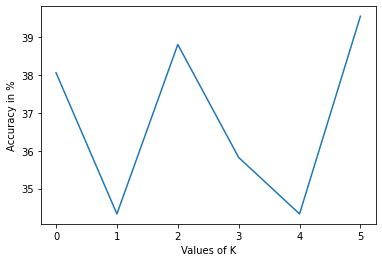

In [103]:
plt.plot(accuracies)
plt.xlabel('Values of K')
plt.ylabel('Accuracy in %')

In [ ]:
datasets = forest_ID3A.prepare_data()

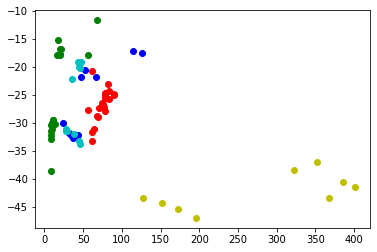

In [ ]:
colors = ['r', 'g', 'b', 'y', 'c']
ci = 0
for dataset in datasets:
    if ci >= 5:
        break
    plt.scatter(dataset['new_cases_classes'], dataset['workplaces'], c = colors[ci])
    ci += 1

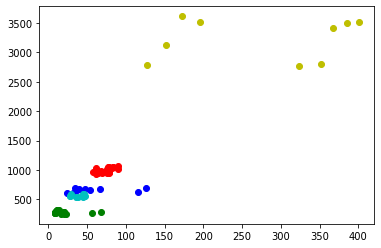

In [104]:
colors = ['r', 'g', 'b', 'y', 'c']
ci = 0
for dataset in datasets:
    if ci >= 5:
        break
    plt.scatter(dataset['new_cases_classes'], dataset['new_deaths'], c = colors[ci])
    ci += 1